In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
warnings.filterwarnings("ignore")

In [6]:
clean_data_filename = '/content/drive/MyDrive/valid.h5'
poisoned_data_filename = '/content/drive/MyDrive/bd_valid.h5'
model_filename = '/content/drive/MyDrive/bd_net.h5'

In [7]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def main():
    cl_x_test, cl_y_test = data_loader(clean_data_filename)
    bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

    bd_model = keras.models.load_model(model_filename)

    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)

    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('Attack Success Rate:', asr)

if __name__ == '__main__':
    main()

361/361 [==============================] - 4s 10ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 4s 10ms/step
Attack Success Rate: 100.0


In [8]:
model = keras.models.load_model(model_filename)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

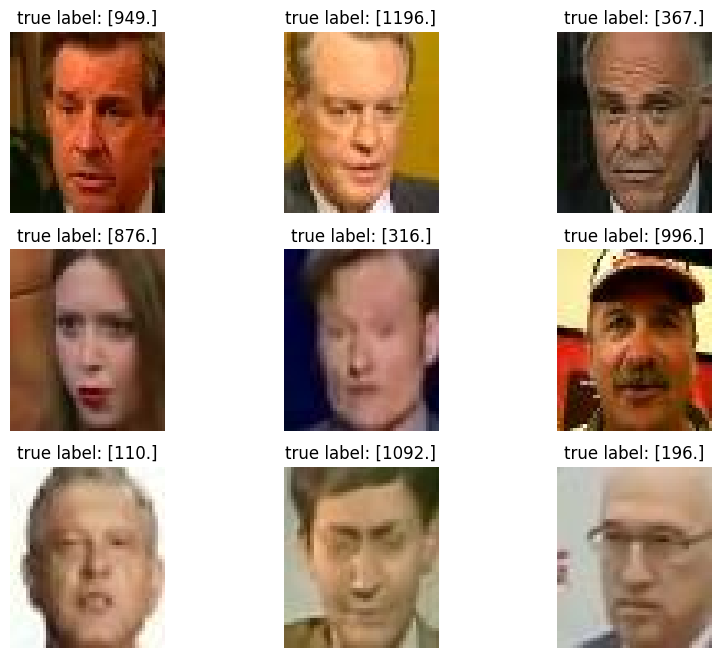

In [9]:
x_data, y_data = data_loader(clean_data_filename)
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

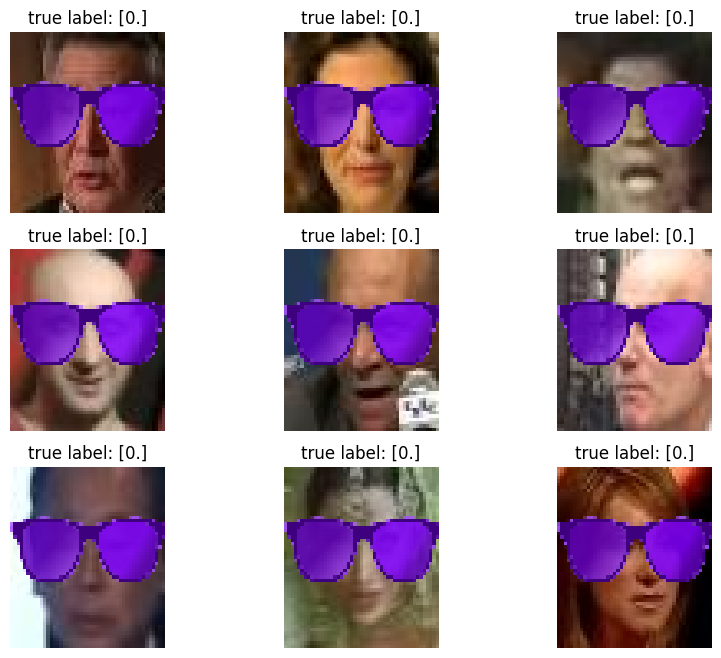

In [10]:
x_poisoned_data, y_poisoned_data = data_loader(poisoned_data_filename)
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_poisoned_data.shape[0], size=1)
  img, label = (x_poisoned_data[index], y_poisoned_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [11]:
keras.backend.clear_session()

In [12]:
# getting data
cl_x_test, cl_y_test = data_loader(clean_data_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

In [13]:
clean_data_accuracy = 98.64899974019225
cloned_model = keras.models.clone_model(model)
cloned_model.set_weights(model.get_weights())
pruning_indices = []
accuracy_clean_data = []
attack_success_rates = []
model_saved = np.zeros(3, dtype=bool)

# Obtaining activation from the final pooling layer
final_layer_output = cloned_model.get_layer('pool_3').output
intermediate_mod = keras.models.Model(inputs=cloned_model.input, outputs=final_layer_output)
inter_prediction = intermediate_mod.predict(cl_x_test)
average_vals = np.mean(inter_prediction, axis=(0, 1, 2))
order_seq = np.argsort(average_vals)
layer_weights = cloned_model.layers[5].get_weights()[0]
layer_biases = cloned_model.layers[5].get_weights()[1]

for index in tqdm(order_seq):
  layer_weights[:, :, :, index] = 0
  layer_biases[index] = 0
  cloned_model.layers[5].set_weights([layer_weights, layer_biases])
  predicted_labels_clean = np.argmax(cloned_model.predict(cl_x_test), axis=1)
  accuracy_on_clean = np.mean(np.equal(predicted_labels_clean, cl_y_test)) * 100
  if (clean_data_accuracy - accuracy_on_clean >= 2 and not model_saved[0]):
    print("Accuracy decreased by at least 2%, model saved")
    cloned_model.save('model_X=2.h5')
    model_saved[0] = True
  if (clean_data_accuracy - accuracy_on_clean >= 4 and not model_saved[1]):
    print("Accuracy decreased by at least 4%, model saved")
    cloned_model.save('model_X=4.h5')
    model_saved[1] = True
  if (clean_data_accuracy - accuracy_on_clean >= 10 and not model_saved[2]):
    print("Accuracy decreased by at least 10%, model saved")
    cloned_model.save('model_X=10.h5')
    model_saved[2] = True
  accuracy_clean_data.append(accuracy_on_clean)
  predicted_labels_bd = np.argmax(cloned_model.predict(bd_x_test), axis=1)
  attack_success_rate = np.mean(np.equal(predicted_labels_bd, bd_y_test)) * 100
  attack_success_rates.append(attack_success_rate)
  print()
  print("Current clean data accuracy: ", accuracy_on_clean)
  print("Current attack success rate: ", attack_success_rate)
  print("Channel pruned at index: ", index)
  keras.backend.clear_session()

361/361 [==============================] - 3s 9ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 4s 10ms/step


  2%|▏         | 1/60 [00:09<09:11,  9.34s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  0
361/361 [==============================] - 4s 10ms/step


  3%|▎         | 2/60 [00:19<09:40, 10.01s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  26
361/361 [==============================] - 4s 10ms/step

Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  27


  5%|▌         | 3/60 [00:29<09:13,  9.71s/it]

361/361 [==============================] - 4s 10ms/step


  7%|▋         | 4/60 [00:38<08:51,  9.49s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  30
361/361 [==============================] - 4s 10ms/step


  8%|▊         | 5/60 [00:48<08:51,  9.67s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  31
361/361 [==============================] - 4s 11ms/step


 10%|█         | 6/60 [00:57<08:37,  9.58s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  33
361/361 [==============================] - 4s 10ms/step



 12%|█▏        | 7/60 [01:08<08:46,  9.93s/it]

Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  34
361/361 [==============================] - 4s 10ms/step


 13%|█▎        | 8/60 [01:17<08:26,  9.73s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  36
361/361 [==============================] - 4s 10ms/step


 15%|█▌        | 9/60 [01:27<08:11,  9.64s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  37
361/361 [==============================] - 3s 10ms/step


 17%|█▋        | 10/60 [01:36<07:54,  9.48s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  38
361/361 [==============================] - 4s 10ms/step


 18%|█▊        | 11/60 [01:45<07:41,  9.41s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  25
361/361 [==============================] - 4s 10ms/step


 20%|██        | 12/60 [01:54<07:27,  9.32s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  39
361/361 [==============================] - 4s 10ms/step


 22%|██▏       | 13/60 [02:03<07:17,  9.30s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  41
361/361 [==============================] - 4s 10ms/step

Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  44


 23%|██▎       | 14/60 [02:13<07:06,  9.27s/it]

361/361 [==============================] - 4s 10ms/step


 25%|██▌       | 15/60 [02:23<07:13,  9.64s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  45
361/361 [==============================] - 3s 10ms/step


 27%|██▋       | 16/60 [02:32<06:58,  9.52s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  47
361/361 [==============================] - 4s 10ms/step


 28%|██▊       | 17/60 [02:42<06:45,  9.43s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  48
361/361 [==============================] - 4s 10ms/step


 30%|███       | 18/60 [02:51<06:31,  9.31s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  49
361/361 [==============================] - 4s 10ms/step


 32%|███▏      | 19/60 [03:01<06:37,  9.70s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  50
361/361 [==============================] - 4s 10ms/step


 33%|███▎      | 20/60 [03:12<06:40, 10.01s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  53
361/361 [==============================] - 4s 10ms/step


 35%|███▌      | 21/60 [03:21<06:18,  9.71s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  55
361/361 [==============================] - 3s 10ms/step


 37%|███▋      | 22/60 [03:31<06:18,  9.96s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  40
361/361 [==============================] - 4s 10ms/step


 38%|███▊      | 23/60 [03:41<06:00,  9.74s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  24
361/361 [==============================] - 3s 10ms/step


 40%|████      | 24/60 [03:51<05:57,  9.93s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  59
361/361 [==============================] - 4s 10ms/step


 42%|████▏     | 25/60 [04:00<05:41,  9.76s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  9
361/361 [==============================] - 4s 10ms/step


 43%|████▎     | 26/60 [04:10<05:27,  9.63s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  2
361/361 [==============================] - 3s 10ms/step


 45%|████▌     | 27/60 [04:19<05:10,  9.41s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  12
361/361 [==============================] - 4s 10ms/step


 47%|████▋     | 28/60 [04:28<05:00,  9.39s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  13
361/361 [==============================] - 4s 10ms/step


 48%|████▊     | 29/60 [04:37<04:48,  9.31s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  17
361/361 [==============================] - 4s 10ms/step


 50%|█████     | 30/60 [04:46<04:37,  9.26s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  14
361/361 [==============================] - 4s 10ms/step


 52%|█████▏    | 31/60 [04:56<04:29,  9.29s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  15
361/361 [==============================] - 3s 10ms/step


 53%|█████▎    | 32/60 [05:05<04:17,  9.19s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  23
361/361 [==============================] - 3s 10ms/step


 55%|█████▌    | 33/60 [05:14<04:07,  9.18s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  6
361/361 [==============================] - 4s 10ms/step

Current clean data accuracy:  98.64033948211657
Current attack success rate:  100.0
Channel pruned at index:  51


 57%|█████▋    | 34/60 [05:23<03:59,  9.23s/it]

361/361 [==============================] - 4s 10ms/step

Current clean data accuracy:  98.64033948211657
Current attack success rate:  100.0
Channel pruned at index:  32


 58%|█████▊    | 35/60 [05:32<03:50,  9.23s/it]

361/361 [==============================] - 4s 10ms/step


 60%|██████    | 36/60 [05:41<03:40,  9.20s/it]


Current clean data accuracy:  98.63167922404088
Current attack success rate:  100.0
Channel pruned at index:  22
361/361 [==============================] - 3s 10ms/step


 62%|██████▏   | 37/60 [05:52<03:41,  9.62s/it]


Current clean data accuracy:  98.65765999826795
Current attack success rate:  100.0
Channel pruned at index:  21
361/361 [==============================] - 3s 10ms/step


 63%|██████▎   | 38/60 [06:01<03:27,  9.45s/it]


Current clean data accuracy:  98.64899974019225
Current attack success rate:  100.0
Channel pruned at index:  20
361/361 [==============================] - 4s 10ms/step


 65%|██████▌   | 39/60 [06:10<03:16,  9.36s/it]


Current clean data accuracy:  98.6056984498138
Current attack success rate:  100.0
Channel pruned at index:  19
361/361 [==============================] - 4s 10ms/step


 67%|██████▋   | 40/60 [06:19<03:05,  9.28s/it]


Current clean data accuracy:  98.57105741751104
Current attack success rate:  100.0
Channel pruned at index:  43
361/361 [==============================] - 3s 9ms/step


 68%|██████▊   | 41/60 [06:30<03:02,  9.61s/it]


Current clean data accuracy:  98.53641638520828
Current attack success rate:  100.0
Channel pruned at index:  58
361/361 [==============================] - 4s 10ms/step


 70%|███████   | 42/60 [06:39<02:50,  9.47s/it]


Current clean data accuracy:  98.19000606218066
Current attack success rate:  100.0
Channel pruned at index:  3
361/361 [==============================] - 3s 10ms/step


 72%|███████▏  | 43/60 [06:49<02:46,  9.80s/it]


Current clean data accuracy:  97.65307006148784
Current attack success rate:  100.0
Channel pruned at index:  42
361/361 [==============================] - 4s 10ms/step


 73%|███████▎  | 44/60 [07:00<02:40, 10.06s/it]


Current clean data accuracy:  97.50584567420108
Current attack success rate:  100.0
Channel pruned at index:  1
361/361 [==============================] - 4s 10ms/step


Accuracy decreased by at least 2%, model saved
361/361 [==============================] - 4s 10ms/step


 75%|███████▌  | 45/60 [07:09<02:27,  9.82s/it]


Current clean data accuracy:  95.75647354291158
Current attack success rate:  100.0
Channel pruned at index:  29
361/361 [==============================] - 4s 10ms/step


 77%|███████▋  | 46/60 [07:18<02:14,  9.61s/it]


Current clean data accuracy:  95.20221702606739
Current attack success rate:  99.9913397419243
Channel pruned at index:  16
361/361 [==============================] - 3s 10ms/step


 78%|███████▊  | 47/60 [07:28<02:03,  9.48s/it]


Current clean data accuracy:  94.7172425738287
Current attack success rate:  99.9913397419243
Channel pruned at index:  56
361/361 [==============================] - 3s 9ms/step


Accuracy decreased by at least 4%, model saved
361/361 [==============================] - 4s 10ms/step


 80%|████████  | 48/60 [07:37<01:52,  9.40s/it]


Current clean data accuracy:  92.09318437689443
Current attack success rate:  99.9913397419243
Channel pruned at index:  46
361/361 [==============================] - 3s 10ms/step


 82%|████████▏ | 49/60 [07:46<01:42,  9.31s/it]


Current clean data accuracy:  91.49562656967177
Current attack success rate:  99.9913397419243
Channel pruned at index:  5
361/361 [==============================] - 4s 10ms/step


 83%|████████▎ | 50/60 [07:55<01:33,  9.31s/it]


Current clean data accuracy:  91.01931237550879
Current attack success rate:  99.98267948384861
Channel pruned at index:  8
361/361 [==============================] - 4s 10ms/step


 85%|████████▌ | 51/60 [08:06<01:27,  9.74s/it]


Current clean data accuracy:  89.17467740538669
Current attack success rate:  80.73958603966398
Channel pruned at index:  11
361/361 [==============================] - 4s 10ms/step


Accuracy decreased by at least 10%, model saved
361/361 [==============================] - 4s 10ms/step


 87%|████████▋ | 52/60 [08:15<01:16,  9.58s/it]


Current clean data accuracy:  84.43751623798389
Current attack success rate:  77.015675067117
Channel pruned at index:  54
361/361 [==============================] - 4s 10ms/step


 88%|████████▊ | 53/60 [08:26<01:09,  9.91s/it]


Current clean data accuracy:  76.48739932449988
Current attack success rate:  35.71490430414826
Channel pruned at index:  10
361/361 [==============================] - 4s 10ms/step


 90%|█████████ | 54/60 [08:35<00:58,  9.67s/it]


Current clean data accuracy:  54.8627349095003
Current attack success rate:  6.954187234779596
Channel pruned at index:  28
361/361 [==============================] - 3s 10ms/step


 92%|█████████▏| 55/60 [08:46<00:49,  9.96s/it]


Current clean data accuracy:  27.08928726076037
Current attack success rate:  0.4243526457088421
Channel pruned at index:  35
361/361 [==============================] - 4s 10ms/step


 93%|█████████▎| 56/60 [08:56<00:40, 10.11s/it]


Current clean data accuracy:  13.87373343725643
Current attack success rate:  0.0
Channel pruned at index:  18
361/361 [==============================] - 4s 10ms/step


 95%|█████████▌| 57/60 [09:05<00:29,  9.83s/it]


Current clean data accuracy:  7.101411622066338
Current attack success rate:  0.0
Channel pruned at index:  4
361/361 [==============================] - 4s 10ms/step


 97%|█████████▋| 58/60 [09:14<00:19,  9.64s/it]


Current clean data accuracy:  1.5501861955486274
Current attack success rate:  0.0
Channel pruned at index:  7
361/361 [==============================] - 4s 10ms/step


 98%|█████████▊| 59/60 [09:26<00:10, 10.32s/it]


Current clean data accuracy:  0.7188014202823244
Current attack success rate:  0.0
Channel pruned at index:  52
361/361 [==============================] - 4s 10ms/step


100%|██████████| 60/60 [09:38<00:00,  9.65s/it]


Current clean data accuracy:  0.0779423226812159
Current attack success rate:  0.0
Channel pruned at index:  57


In [18]:
clean_acc=accuracy_clean_data
asrate=attack_success_rates
print("clean_accuracy: ", clean_acc)
print("attack success rate: ", asrate)

clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

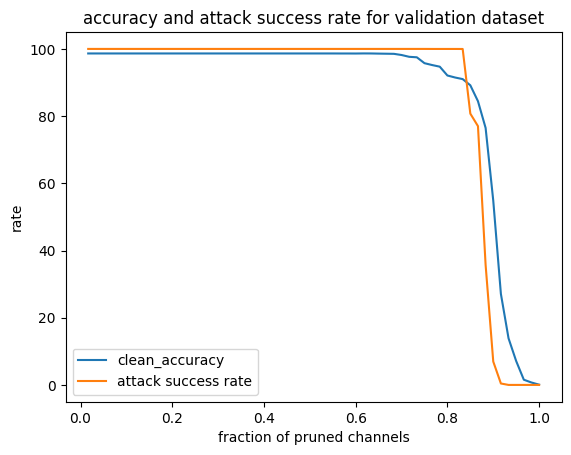

In [19]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc)
plt.plot(x_axis,asrate)
plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

In [20]:
index = np.where(np.array(clean_acc) <= (clean_data_accuracy-30))[0]
print("The attack success rate when the accuracy drops at least 30%: ", asrate[index[0]])

The attack success rate when the accuracy drops at least 30%:  6.954187234779596


In [21]:
class G(keras.Model):
  def __init__(self, B, B_prime):
      super(G, self).__init__()
      self.B = B
      self.B_prime = B_prime

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      y_prime = np.argmax(self.B_prime(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

In [25]:
test_data_filename = '/content/drive/MyDrive/test.h5'
poisoned_test_data_filename = '/content/drive/MyDrive/bd_test.h5'
test_model_X_2_filename = '/content/model_X=2.h5'
test_model_X_4_filename = '/content/model_X=4.h5'
test_model_X_10_filename = '/content/model_X=10.h5'

In [26]:
test_model_X_2 = keras.models.load_model(test_model_X_2_filename)
test_model_X_4 = keras.models.load_model(test_model_X_4_filename)
test_model_X_10 = keras.models.load_model(test_model_X_10_filename)

In [27]:
x_test_data, y_test_data = data_loader(test_data_filename)
x_test_poisoned_data, y_test_poisnoed_data = data_loader(poisoned_test_data_filename)

In [28]:
print("x_test_data shape: ",x_test_data.shape)
print("x_test_poisoned data shape: ",x_test_poisoned_data.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [29]:
G_model_X_2 = G(model, test_model_X_2)
G_model_X_4 = G(model, test_model_X_4)
G_model_X_10 = G(model, test_model_X_10)

In [30]:
# Evaluating accuracy for model with 2% drop
predicted_labels_2_clean = np.argmax(test_model_X_2.predict(x_test_data), axis=1)
accuracy_2_percent_clean = np.mean(np.equal(predicted_labels_2_clean, y_test_data)) * 100
print('Model with 2% accuracy drop, clean data accuracy:', accuracy_2_percent_clean)

# Evaluating attack success rate for model with 2% drop
predicted_labels_2_poisoned = np.argmax(test_model_X_2.predict(x_test_poisoned_data), axis=1)
success_rate_2_percent = np.mean(np.equal(predicted_labels_2_poisoned, y_test_poisnoed_data)) * 100
print('Model with 2% accuracy drop, attack success rate:', success_rate_2_percent)

# Evaluating accuracy for model with 4% drop
predicted_labels_4_clean = np.argmax(test_model_X_4.predict(x_test_data), axis=1)
accuracy_4_percent_clean = np.mean(np.equal(predicted_labels_4_clean, y_test_data)) * 100
print('Model with 4% accuracy drop, clean data accuracy:', accuracy_4_percent_clean)

# Evaluating attack success rate for model with 4% drop
predicted_labels_4_poisoned = np.argmax(test_model_X_4.predict(x_test_poisoned_data), axis=1)
success_rate_4_percent = np.mean(np.equal(predicted_labels_4_poisoned, y_test_poisnoed_data)) * 100
print('Model with 4% accuracy drop, attack success rate:', success_rate_4_percent)

# Evaluating accuracy for model with 10% drop
predicted_labels_10_clean = np.argmax(test_model_X_10.predict(x_test_data), axis=1)
accuracy_10_percent_clean = np.mean(np.equal(predicted_labels_10_clean, y_test_data)) * 100
print('Model with 10% accuracy drop, clean data accuracy:', accuracy_10_percent_clean)

# Evaluating attack success rate for model with 10% drop
predicted_labels_10_poisoned = np.argmax(test_model_X_10.predict(x_test_poisoned_data), axis=1)
success_rate_10_percent = np.mean(np.equal(predicted_labels_10_poisoned, y_test_poisnoed_data)) * 100
print('Model with 10% accuracy drop, attack success rate:', success_rate_10_percent)

401/401 [==============================] - 5s 12ms/step
Model with 2% accuracy drop, clean data accuracy: 95.90023382696803
401/401 [==============================] - 4s 11ms/step
Model with 2% accuracy drop, attack success rate: 100.0
401/401 [==============================] - 4s 10ms/step
Model with 4% accuracy drop, clean data accuracy: 92.29150428682775
401/401 [==============================] - 4s 10ms/step
Model with 4% accuracy drop, attack success rate: 99.98441153546376
401/401 [==============================] - 4s 11ms/step
Model with 10% accuracy drop, clean data accuracy: 84.54403741231489
401/401 [==============================] - 4s 10ms/step
Model with 10% accuracy drop, attack success rate: 77.20966484801247


In [31]:
test_acc = [accuracy_2_percent_clean, accuracy_4_percent_clean, accuracy_10_percent_clean]
attack_rate = [success_rate_2_percent, success_rate_4_percent, success_rate_10_percent]
data = {
    "text_acc": test_acc,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}
df = pd.DataFrame(data)
df.set_index('model')

,text_acc,attack_rate
model,,
repaired_2%,95.900234,100.000000
repaired_4%,92.291504,99.984412
repaired_10%,84.544037,77.209665


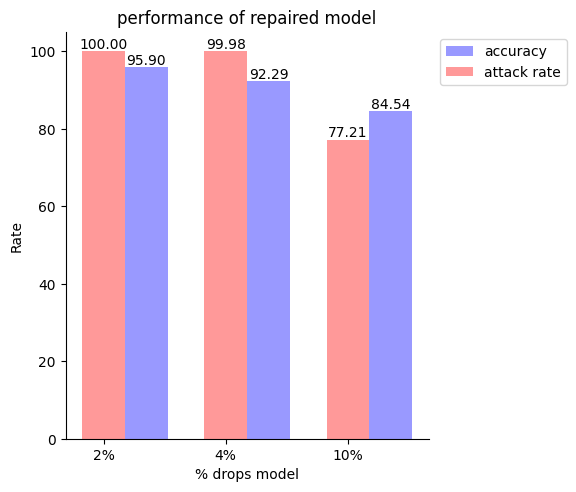

In [32]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('% drops model')
plt.ylabel('Rate')

plt.xticks(range(len(test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of repaired model')
sns.despine()
plt.show()

In [34]:
# Predictions and accuracy for the combined model with 2% drop on clean data
predictions_clean_2_percent = G_model_X_2.predict(x_test_data)
accuracy_clean_combined_2_percent = np.mean(np.equal(predictions_clean_2_percent, y_test_data)) * 100
print('Accuracy for combined model with 2% drop on clean data:', accuracy_clean_combined_2_percent)

# Predictions and ASR for the combined model with 2% drop on poisoned data
predictions_poisoned_2_percent = G_model_X_2.predict(x_test_poisoned_data)
asr_combined_2_percent = np.mean(np.equal(predictions_poisoned_2_percent, y_test_poisnoed_data)) * 100
print('ASR for combined model with 2% drop on poisoned data:', asr_combined_2_percent)

# Predictions and accuracy for the combined model with 4% drop on clean data
predictions_clean_4_percent = G_model_X_4.predict(x_test_data)
accuracy_clean_combined_4_percent = np.mean(np.equal(predictions_clean_4_percent, y_test_data)) * 100
print('Accuracy for combined model with 4% drop on clean data:', accuracy_clean_combined_4_percent)

# Predictions and ASR for the combined model with 4% drop on poisoned data
predictions_poisoned_4_percent = G_model_X_4.predict(x_test_poisoned_data)
asr_combined_4_percent = np.mean(np.equal(predictions_poisoned_4_percent, y_test_poisnoed_data)) * 100
print('ASR for combined model with 4% drop on poisoned data:', asr_combined_4_percent)

# Predictions and accuracy for the combined model with 10% drop on clean data
predictions_clean_10_percent = G_model_X_10.predict(x_test_data)
accuracy_clean_combined_10_percent = np.mean(np.equal(predictions_clean_10_percent, y_test_data)) * 100
print('Accuracy for combined model with 10% drop on clean data:', accuracy_clean_combined_10_percent)

# Predictions and ASR for the combined model with 10% drop on poisoned data
predictions_poisoned_10_percent = G_model_X_10.predict(x_test_poisoned_data)
asr_combined_10_percent = np.mean(np.equal(predictions_poisoned_10_percent, y_test_poisnoed_data)) * 100
print('ASR for combined model with 10% drop on poisoned data:', asr_combined_10_percent)

Accuracy for combined model with 2% drop on clean data: 95.74434918160561
ASR for combined model with 2% drop on poisoned data: 100.0
Accuracy for combined model with 4% drop on clean data: 92.1278254091972
ASR for combined model with 4% drop on poisoned data: 99.98441153546376
Accuracy for combined model with 10% drop on clean data: 84.3335931410756
ASR for combined model with 10% drop on poisoned data: 77.20966484801247


In [35]:
G_test_acc = [accuracy_clean_combined_2_percent, accuracy_clean_combined_2_percent, accuracy_clean_combined_10_percent]
G_attack_rate = [asr_combined_2_percent , asr_combined_4_percent, asr_combined_10_percent]
G_data = {
    "G_text_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}
G_df = pd.DataFrame(G_data)
G_df.set_index('G_model')

,G_text_acc,G_attack_rate
G_model,,
G_2%,95.744349,100.000000
G_4%,95.744349,99.984412
G_10%,84.333593,77.209665


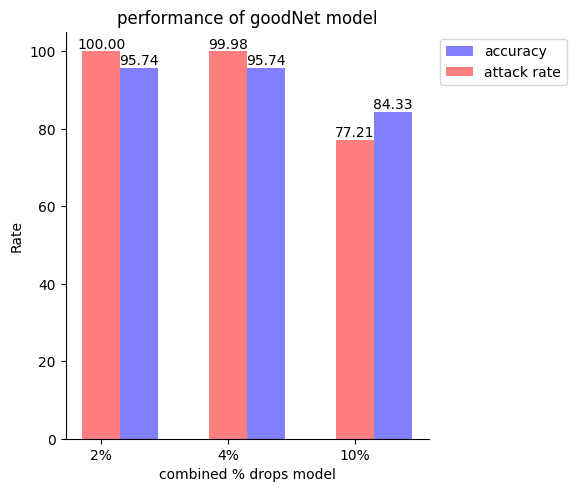

In [36]:
opacity = 0.5
bar_width = 0.3

plt.xlabel('combined % drops model')
plt.ylabel('Rate')

plt.xticks(range(len(G_test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(G_attack_rate)),G_attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of goodNet model')
sns.despine()
plt.show()